### Merge and combine yearly pitching and batting data

In [1]:
p2s_mapping = {
    'ARI': 'ARI',
    'OAK': 'ATH',
    'ATL': 'ATL',
    'BAL': 'BAL',
    'BOS': 'BOS',
    'CHC': 'CHC',
    'CHW': 'CWS',
    'CIN': 'CIN',
    'CLE': 'CLE',
    'COL': 'COL',
    'DET': 'DET',
    'HOU': 'HOU',
    'KCR': 'KC',
    'LAA': 'LAA',
    'LAD': 'LAD',
    'MIA': 'MIA',
    'FLA': 'MIA',
    'MIL': 'MIL',
    'MIN': 'MIN',
    'NYM': 'NYM',
    'NYY': 'NYY',
    'OAK': 'OAK',
    'PHI': 'PHI',
    'PIT': 'PIT',
    'SDP': 'SD',
    'SEA': 'SEA',
    'SFG': 'SF',
    'STL': 'STL',
    'TBR': 'TB',
    'TEX': 'TEX',
    'TOR': 'TOR',
    'WSN': 'WSH'
}

In [2]:
import pandas as pd
import numpy as np

# Taking CSV files and collating them for both batters and pitchers
df_list = []
for year in range(2011, 2026):
    df = pd.read_csv(f'csv_files/stan_batting/stan_batting_{year}.csv', encoding='utf-8')
    df['Year'] = year
    df_list.append(df)

merged_batting_df = pd.concat(df_list, ignore_index=True)

df_list = []
for year in range(2011, 2026):
    df = pd.read_csv(f'csv_files/stan_pitching/stan_pitching_{year}.csv', encoding='utf-8')
    df['Year'] = year
    df_list.append(df)

merged_pitching_df = pd.concat(df_list, ignore_index=True)
merged_pitching_df = merged_pitching_df.rename({'R': 'pR', 'H': 'pH', 'HR': 'pHR', 'BB': 'pBB', 'SO': 'pSO', 'HBP': 'pHBP', 'IBB': 'pIBB'}, axis=1)

# Concatenate two dataframes with different columns, filling missing columns with NaN
concatenated_df = pd.concat([merged_batting_df, merged_pitching_df], ignore_index=True, sort=False)
concatenated_df.rename(columns={'Player': 'Name'}, inplace=True)
concatenated_df['Team'] = concatenated_df['Team'].map(p2s_mapping) # map team names to consistent format
concatenated_df.dropna(subset=['Team'], inplace=True) # drop rows where team is NaN ( average stats and 2/3/4 team players)

### Read salary data, build id to merge batting/pitching with salary

In [3]:
import unicodedata

salary_df = pd.read_excel('csv_files/MLB_Salaries.xlsx')

salary_df.dropna(subset=['Player'], inplace=True) # drop rows where Player is NaN
salary_df = salary_df[['Player','Position','Status','Payroll Salary','Team','Year']]
salary_df.rename(columns={'Payroll Salary': 'Salary'}, inplace=True) # rename Payroll Salary to Salary
salary_df['Year'] = salary_df['Year'].astype(int)

In [4]:
player_data = concatenated_df
def normalize_name(name):
    # Normalize to NFKD and encode to ASCII, ignoring errors (removes accents)
    name =  unicodedata.normalize('NFKD', name).encode('ASCII', 'ignore').decode('utf-8')
    name = name.lower().replace('.', '').replace("'", '').strip()
    name = name.rstrip("*#") # remove trailing * or # if present
    return name

salary_df['Name'] = salary_df['Player'].apply(normalize_name)
player_data['Name'] = player_data['Name'].apply(normalize_name)


# create alteration function to get 1st letter of first name and first 3 letters of last name
def convert_name(row):
    parts = row['Name'].split(' ')
    max_idx = (min(1, len(parts[0])))  # Ensure at most 1 characters are taken
    part1 = parts[0][:max_idx]  # First letter of the first name
    part2 = ''
    last_name_len = '0'
    for part in parts[1:]:
        if (len(part)>=3) or (part == parts[-1]): # check that part is either final part or at least 3 characters long
            max_idx = min(4, len(part))  # Ensure at most 4 characters are taken
            part2 = part[:max_idx]  # First three letters of the last name
            last_name_len = str(len(part)) # Length of the last name part
            break # only use the first valid last name part
    team = row['Team']  
    year = row['Year']
    return part1 + part2 + last_name_len + team.lower() + str(year)

salary_df['id'] = salary_df.apply(convert_name, axis=1)
player_data['id'] = player_data.apply(convert_name, axis=1)
player_data

,Rk,Name,Age,Team,Lg,WAR,G,PA,AB,R,...,BF,ERA+,FIP,WHIP,H9,HR9,BB9,SO9,SO/BB,id
0,1.0,jacoby ellsbury,27.0,BOS,AL,8.3,158.0,732.0,660.0,119.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,jells8bos2011
1,2.0,dustin pedroia,27.0,BOS,AL,8.0,159.0,731.0,635.0,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dpedr7bos2011
2,3.0,ian kinsler,29.0,TEX,AL,7.0,155.0,723.0,620.0,121.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ikins7tex2011
4,4.0,michael bourn,28.0,HOU,NL,2.2,105.0,473.0,429.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mbour5hou2011
5,4.0,michael bourn,28.0,ATL,NL,0.8,53.0,249.0,227.0,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mbour5atl2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32989,855.0,jayvien sandridge,26.0,NYY,AL,-0.1,1.0,NaN,NaN,NaN,...,6.0,24.0,30.15,4.5,13.5,13.5,27.0,27.0,1.0,jsand9nyy2025
32990,856.0,austin slater,32.0,NYY,AL,0.0,1.0,NaN,NaN,NaN,...,3.0,NaN,3.15,1.5,13.5,0.0,0.0,0.0,NaN,aslat6nyy2025
32991,857.0,luis torrens,29.0,NYM,NL,-0.2,2.0,NaN,NaN,NaN,...,8.0,12.0,46.65,9.0,67.5,27.0,13.5,0.0,0.0,ltorr7nym2025
32993,859.0,nicky lopez,30.0,LAA,AL,0.0,1.0,NaN,NaN,NaN,...,2.0,NaN,12.15,3.0,0.0,0.0,27.0,0.0,0.0,nlope5laa2025


### Unique ID Creation

#### Check salary for duplicate ids

In [5]:
from collections import Counter

year = 2024 # limit to single year for testing
print('unique ids in salary: {}'.format(salary_df[salary_df['Year'] == year]['id'].nunique()))
print('unique ids in player_data: {}'.format(player_data[player_data['Year'] == year]['id'].nunique()))

# get df of ids that have multiple instances
def check_doubled_ids(df):
    dfs = []
    for year in range(2011, 2026):
        counter = Counter(df[df['Year'] == year]['id'])
        doubled_ids = [item for item, count in counter.items() if count > 1]
        dfs.append(df[df['id'].isin(doubled_ids) & (df['Year'] == year)])
    df = pd.concat(dfs)
    df.sort_values(by=['id', 'Salary'], ascending=[True, False], inplace=True)
    return df

# if there are two players with the same id keep the one with the higher salary
def keep_higher_salary(df):
    # count the ids that appear more than once in salary_df for the given year
    temp_df = check_doubled_ids(df.copy())
    drop_idxs = []
    for id in temp_df['id'].unique():
        names = temp_df[temp_df.id == id]
        drop_idxs.append(names.index[1:]) # keep the first instance, drop the rest

    drop_idxs_flat = [idx for sublist in drop_idxs for idx in sublist]
    df = df.drop(drop_idxs_flat)
    df = df.reset_index(drop=True)
    return df

salary_df = keep_higher_salary(salary_df)

unique ids in salary: 840
unique ids in player_data: 1648


#### Check that salary matches 1 row in player data

In [6]:
def get_salary_no_data(salary_df, player_df):
    sal_df = salary_df.copy()
    sal_df['player_conection'] = sal_df['id'].apply(lambda x: 1 if x in player_df['id'].values else 0)
    sal_df = sal_df[sal_df['player_conection'] == 0]
    sal_df.sort_values(by=['Year', 'Name'], inplace=True)
    return sal_df[['Name','id', 'Team', 'Year']]

print(len(salary_df))
get_salary_no_data(salary_df, player_data)

14323


,Name,id,Team,Year
14068,adam wainwright,awain10stl2011,STL,2011
14185,adeiny hechavarria,ahech11tor2011,TOR,2011
13528,alberto arias,aaria5hou2011,HOU,2011
14224,anthony rendon,arend6wsh2011,WSH,2011
13543,arcenio leon,aleon4hou2011,HOU,2011
...,...,...,...,...
1598,hyun-jin ryu,hryu3tor2023,TOR,2023
1407,ji-hwan bae,jbae3pit2023,PIT,2023
1594,matt bush,mbush4tex2023,TEX,2023
334,ryan gusto,rgust5hou2024,HOU,2024


### Final Merge

In [7]:
final_merge = player_data.merge(salary_df[['id','Position','Status','Salary']], how='left', on='id')
final_merge.dropna(subset=['Salary'], inplace=True) # drop rows where Salary is NaN
shohei = final_merge[final_merge['Name'] == 'shohei ohtani'] # Create a new dataframe containing only Shohei Ohtani
final_merge = final_merge[final_merge['Name'] != 'shohei ohtani'] # Remove him from the data to add back after we manipulate the batting data

### Remove batting data for pitchers and pitching data for batters

In [8]:
pitcher_positions = {'SP', 'RP', 'CL', 'P', 'SP/DH'}
batter_positions  = {'C','1B','2B','3B','SS','LF','CF','RF','OF','INF','DH','DH/DH'} # Accounting of batting and pitching positions

# Remove these columns for pitchers
batting_cols = [
    'PA','AB','R','H','2B','3B','HR','RBI','SB','CS','BB','SO','BA','OBP','SLG',
    'OPS','OPS+','rOBA','Rbat+','TB','GIDP','HBP','SH','SF','IBB'
]

# Remove these columns for batters
pitching_cols = [
    'W','L','W-L%','ERA','GS','GF','CG','SHO','SV','IP','pH','pR','ER','pHR',
    'pBB','pIBB','pSO','pHBP','BK','WP','BF','ERA+','FIP','WHIP','H9','HR9',
    'BB9','SO9','SO/BB'
]

# These columns are shared
shared_cols = [
    'Rk','Name','Age','Team','Lg','WAR','G','Pos','Awards','Player-additional',
    'Year','id','Position','Status','Salary'
]

batting_cols = [c for c in batting_cols if c in final_merge.columns]
pitching_cols = [c for c in pitching_cols if c in final_merge.columns]

is_pitcher = final_merge['Position'].isin(pitcher_positions)
is_batter  = final_merge['Position'].isin(batter_positions)

final_merge.loc[is_pitcher, batting_cols] = np.nan
final_merge.loc[is_batter, pitching_cols] = np.nan

# Drop rows where both PA and IP are missing
final_merge.drop(final_merge[final_merge['PA'].isna() & final_merge['IP'].isna()].index, inplace=True)

### Counting number of batters and pitchers on each team with a pivot

In [9]:
final_merge['Position'] = final_merge['Position'].astype(str).str.strip().str.upper()

pitcher_positions = {'SP', 'RP', 'CL', 'P', 'SP/DH'}
batter_positions  = {'C','1B','2B','3B','SS','LF','CF','RF','OF','INF','DH','DH/DH'}

final_merge['Role'] = final_merge['Position'].apply(lambda x: 'Pitcher' if x in pitcher_positions else ('Batter' if x in batter_positions else None))
shohei['Role'] = np.where(shohei['IP'].notna(), 'Pitcher', 'Batter')
counts = final_merge.groupby(['Team', 'Year', 'Role']).size().unstack(fill_value=0)

pitchers_pivot = counts['Pitcher'].unstack(fill_value=0)
batters_pivot = counts['Batter'].unstack(fill_value=0)

shohei['Role'] = np.where(shohei['IP'].notna(), 'Pitcher', 'Batter') # Put Shohei back in the data with a role assigned based on IP
final_merge = pd.concat([final_merge, shohei])

print("\n=== Pitchers per Team per Year ===")
print(pitchers_pivot.to_string())

print("\n=== Batters per Team per Year ===")
print(batters_pivot.to_string())


=== Pitchers per Team per Year ===
Year  2011  2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  2022  2023  2024
Team                                                                                    
ARI     17    21    16    17    22    18    17    19    19    14    16    14    14    13
ATL     19    19    17    19    18    19    19    20    20    15    15    14    15    14
BAL     18    17    18    15    18    19    17    19    18    15    15    14    15    14
BOS     23    20    22    17    18    18    19    19    22    15    15    13    14    14
CHC     19    22    20    20    19    19    18    20    20    15    16    14    14    14
CIN     17    16    16    19    19    17    20    17    18    14    15    14    13    14
CLE     20    21    22    14    17    19    18    16    18    14    16    14    14    14
COL     15    22    21    20    21    19    19    17    19    15    16    15    14    14
CWS     20    19    16    14    19    19    15    16    15    15    15    

### Taking the top 13 players for each team for hitters and batters

In [10]:
top_batters = (final_merge.groupby(['Team', 'Year'], group_keys=False).apply(lambda g: g.nlargest(13, 'PA')))
top_pitchers = (final_merge.groupby(['Team', 'Year'], group_keys=False).apply(lambda g: g.nlargest(13, 'IP')))

top_players = pd.concat([top_batters, top_pitchers], ignore_index=True)
top_players.to_csv('csv_files/data_merge_output.csv', index=False)

### Data distribution

Rk: 1 nulls


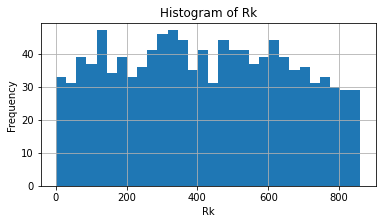

Player: 0 nulls
Age: 1 nulls


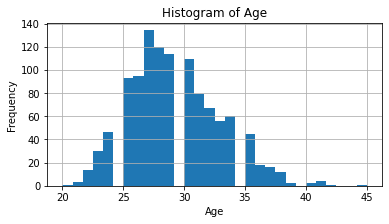

Team: 1 nulls
Lg: 1 nulls


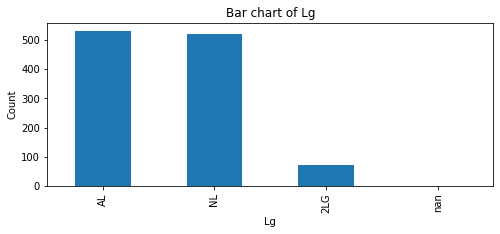

WAR: 1 nulls


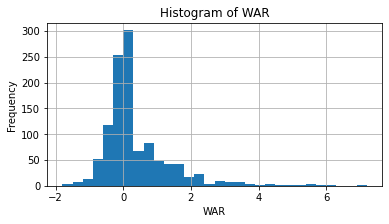

W: 1 nulls


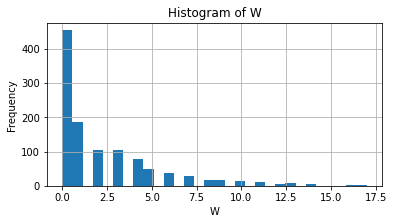

L: 1 nulls


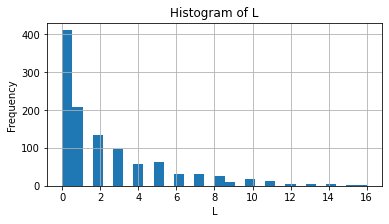

W-L%: 314 nulls


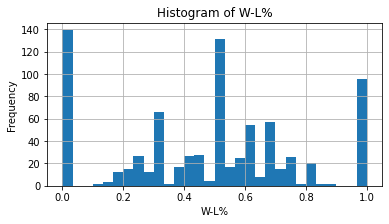

ERA: 0 nulls


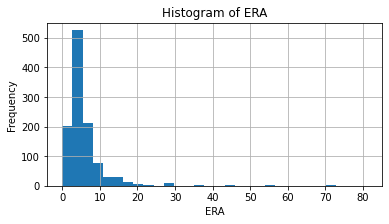

G: 1 nulls


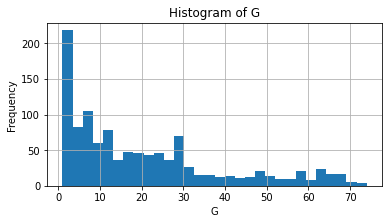

GS: 1 nulls


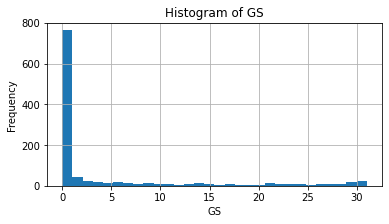

GF: 1 nulls


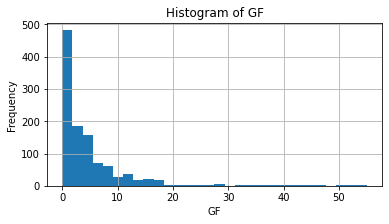

CG: 1 nulls


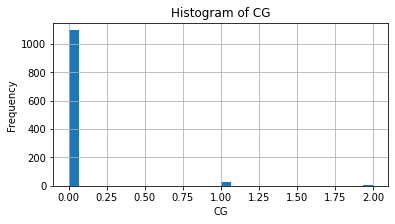

SHO: 1 nulls


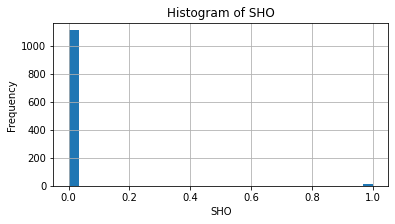

SV: 1 nulls


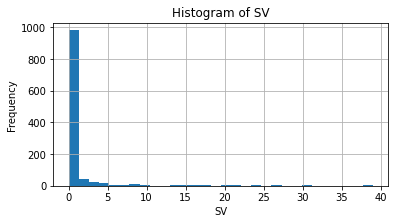

IP: 1 nulls


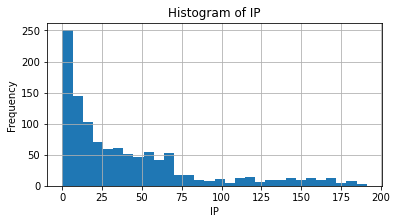

H: 1 nulls


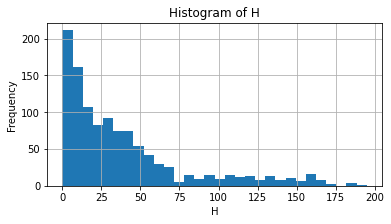

R: 1 nulls


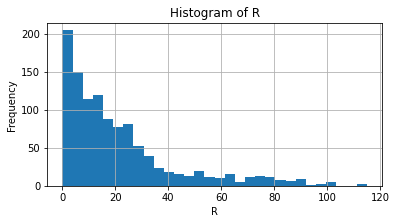

ER: 1 nulls


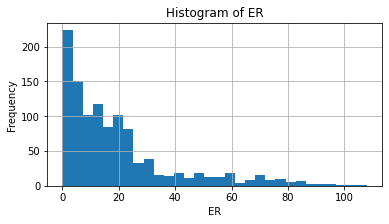

HR: 1 nulls


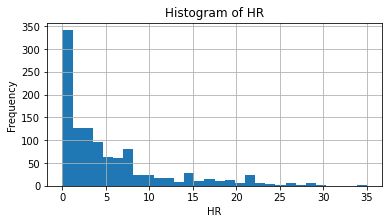

BB: 1 nulls


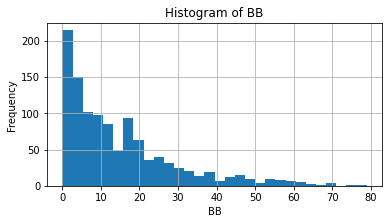

IBB: 1 nulls


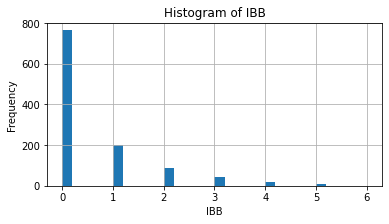

SO: 1 nulls


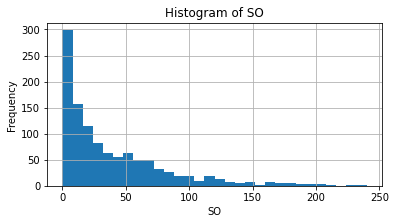

HBP: 1 nulls


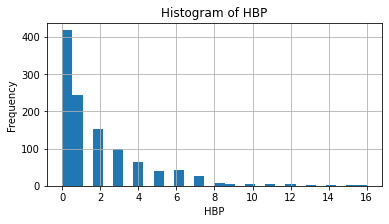

BK: 1 nulls


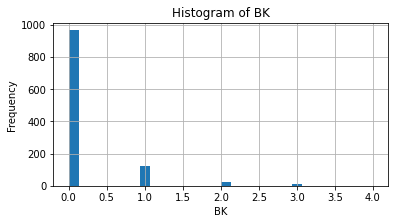

WP: 1 nulls


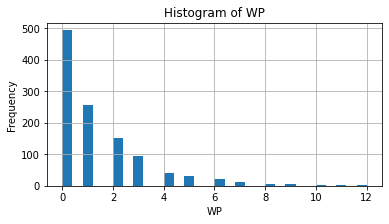

BF: 1 nulls


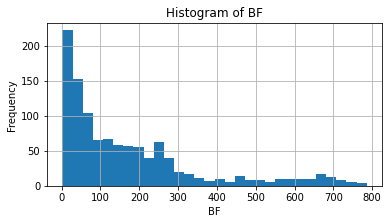

ERA+: 57 nulls


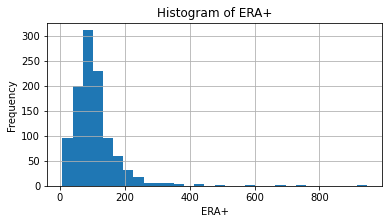

FIP: 0 nulls


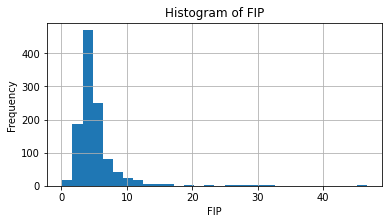

WHIP: 0 nulls


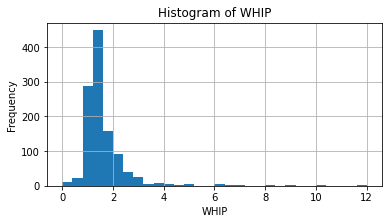

H9: 0 nulls


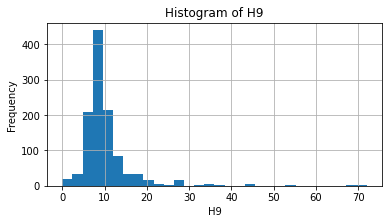

HR9: 0 nulls


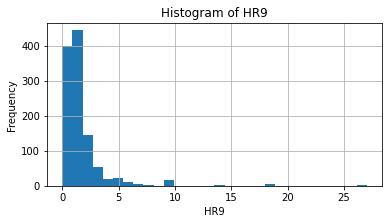

BB9: 0 nulls


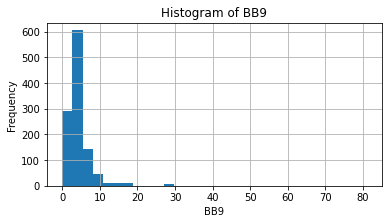

SO9: 0 nulls


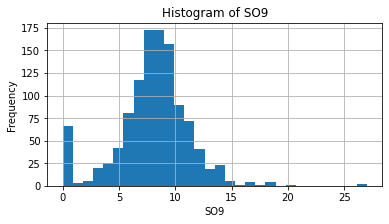

SO/BB: 60 nulls


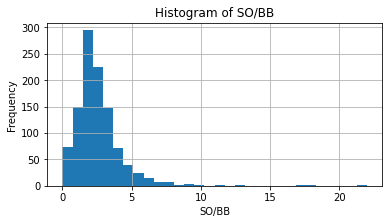

Awards: 1086 nulls


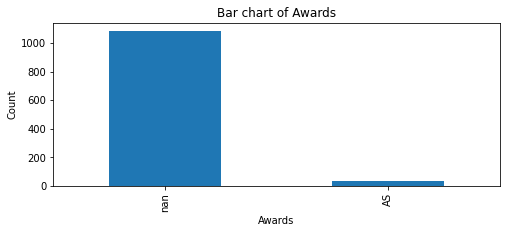

Player-additional: 0 nulls
Year: 0 nulls


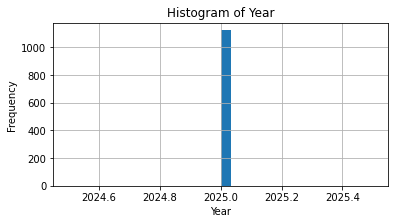

In [11]:
import matplotlib.pyplot as plt

for col in df.columns:
    null_count = df[col].isnull().sum()
    print(f"{col}: {null_count} nulls")
    if df[col].dtype in ['float64', 'int64']:
        plt.figure(figsize=(6, 3))
        df[col].hist(bins=30)
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
    elif df[col].dtype == 'object':
        # For categorical/object columns, plot bar chart of value counts if unique values are not too many
        unique_vals = df[col].nunique(dropna=True)
        if unique_vals < 30:
            plt.figure(figsize=(8, 3))
            df[col].value_counts(dropna=False).plot(kind='bar')
            plt.title(f'Bar chart of {col}')
            plt.xlabel(col)
            plt.ylabel('Count')
            plt.show()